In [20]:
from matplotlib import pyplot as plt
plt.style.use('bmh')
import numpy as np
import numpy.matlib
import sympy
import sys 
from time import time
import scipy

from scipy import stats
from scipy import sparse
from scipy.sparse import linalg
from scipy.sparse.linalg import spsolve
from scipy.stats import norm

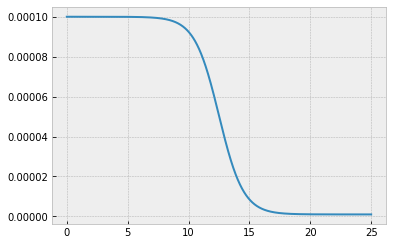

In [21]:
sympy.init_printing()
z = sympy.symbols('z')
H=25.0
K0=1e-4
K1=1e-6
turncation=H/2
scale=1.0
sym_Diffu = K0+(K1-K0)*(1-1/(1+sympy.exp(-(turncation-z)/scale)))
sym_dKdz = sympy.diff(sym_Diffu, z, 1)
sym_d2Kdz2 =  sympy.diff(sym_Diffu, z, 2)
sym_d3Kdz3   =  sympy.diff(sym_Diffu, z, 3)

Diffu  =  sympy.utilities.lambdify(z,sym_Diffu,np)
dKdz   =  sympy.utilities.lambdify(z,sym_dKdz,np)
d2Kdz =  sympy.utilities.lambdify(z,sym_d2Kdz2,np)
d3Kdz = sympy.utilities.lambdify(z,sym_d3Kdz3,np)

zc=np.linspace(0, H, 2500)
plt.plot(zc, Diffu(zc))

del z #delete the symbol

In [22]:
def step_e(z,H,dt,N_sample,w=0):
    dW=np.random.normal(0,np.sqrt(dt),N_sample) 
    
    a=w+dKdz(z)
    b=np.sqrt(2*Diffu(z))
    temp=z+a*dt+b*dW
    temp=np.where(temp<0, -temp ,temp)
    temp=np.where(temp>H, 2*H-temp,temp)
    return temp

def step_v(z,H,dt,N_sample,dW=None,w=0):
    if dW is None:
        dW=np.random.normal(0,np.sqrt(dt),N_sample)
    a=w+dKdz(z)
    b=np.sqrt(2*Diffu(z + 1/2*a*dt))
    temp= z + a*dt + b*dW
    temp=np.where(temp<0, -temp ,temp)
    temp=np.where(temp>H, 2*H-temp,temp)
    return temp

def step_m(z,H,dt,N_sample,dW=None,w=0):
    if dW is None:
        dW=np.random.normal(0,np.sqrt(dt),N_sample)
    
    k=Diffu(z)
    dkdz=dKdz(z)
    sqrt2k=np.sqrt(2*k)
    
    a= w + dkdz
    b= sqrt2k 
    db=dkdz/b
    #temp= z + w*dt + (1/2)*dkdz*(dW*dW+dt) + b*dW
    temp= z+ a*dt+1/2*(b*db)*(dW*dW-dt)+b*dW
    
    temp=np.where(temp<0, -temp ,temp)
    temp=np.where(temp>H, 2*H-temp,temp)
    return temp

def step_m2(z,H,dt,N_sample,w=0):
    dW=np.random.normal(0,np.sqrt(dt),N_sample)
    
    k=Diffu(z)
    dkdz=dKdz(z)
    ddkdz=d2Kdz(z)
    dddkdz=d3Kdz(z)
    sqrt2k=np.sqrt(2*k)
    
    a= w + dkdz
    da=ddkdz
    dda=dddkdz
    b= sqrt2k 
    db=dkdz/b
    ddb=ddkdz/b - ((dkdz)**2)/b**3
    ab=da*b+a*db
    
    temp= z + a*dt+b*dW+1/2*b*db*(dW*dW-dt)+1/2*(ab+1/2*ddb*b**2)*dW*dt+\
            1/2*(a*da+1/2*dda*b**2)*dt**2
            
    temp=np.where(temp<0, -temp ,temp)
    temp=np.where(temp>H, 2*H-temp,temp)
    return temp

## Lagrangian model

In [23]:
def Lagrangian(H=None, dtLa=None, T=None, Np=None, mu=None, sigma=None):
    if (H or dtLa or T or Np or mu or sigma) == None:
        print("Using default values")
        H=25.0
        dtLa=1200  
        T=0.5*3600 
        Np=2000000             

    Nt=int(T/dtLa)
    
    if (T%dtLa) != 0:
        print("Tmax is not dividable to dtLa")
        sys.exit(0)

    LaM2=np.random.normal(mu, sigma, Np)
    LaM1=LaM2.copy()
    LaVi=LaM2.copy()
    LaEM=LaM2.copy()
    
    start=time()
    print("---Lagrangian part---")
    print("Number of time step: ", Nt)
    print("Number of particles: ", Np)
    print("dt of Lagrangian: ", dtLa)
    for i in range(Nt):
        print("\r","Working: ", i, " of ", Nt, end="\r", flush=True)       
        LaM2=step_m2(LaM2,H,dtLa,Np)
        LaEM=step_e(LaEM,H,dtLa,Np)
        LaVi=step_v(LaVi,H,dtLa,Np)
        LaM1=step_m(LaM1,H,dtLa,Np)

    """
    1. Calculate the "$order" momentum of Eulerian.
    2. Calculate the "$order" momentum of Lagrangian.
    """
    order=1
    momLagM2=np.sum(LaM2**order)/LaM2.size
    momLagEM=np.sum(LaEM**order)/LaEM.size
    momLagVi=np.sum(LaVi**order)/LaVi.size
    momLagM1=np.sum(LaM1**order)/LaM1.size
    
    print("Order: ", order)
    print("Done! Time used: ", time()-start)
    return momLagM2,momLagEM,momLagVi,momLagM1


## Eulerian model
    The crankNicloson is borrowed from Tor Nordam.

In [24]:

def crankNicolson(C0, D0, X, dt, Tmax):
    # Numerical parameters
    dx = X[1] - X[0]
    Nx = X.size
    Nt = int(Tmax / dt)
    a  = dt/(8*dx**2)
    b  = dt/(4*dx)
    
    # Problem arrays
    # Pad with halo cells and 
    # copy elements onto boundary
    C      = np.zeros((Nt+1, Nx))
    C[0,:] = C0
    # Diffusivity (here constant in time)
    D      = np.zeros(Nx)
    D[:]   = D0
    # Create system matrices
    # Equation is L C_i = R C_{i+1}
    # Left hand side
    L = np.zeros((Nx, Nx))
    # Fill non-boundary points first
    L[1:-1,1:-1] += np.diag(1 - 8*a*D[1:-1], 0)
    L[:-1,:-1] += np.diag(-a*(D[2:]-D[:-2]) + 4*a*D[ 1:-1], -1)
    L[1:,1:] += np.diag( a*(D[2:]-D[:-2]) + 4*a*D[1:-1], +1)
    # No-diffusive-flux BC at top
    L[ 0, 0] = 1 - 8*a*D[0]
    L[ 0, 1] = 8*a*D[0]
    # No-diffusive-flux  BC at bottom
    L[-1,-1] = 1 - 8*a*D[-1]
    L[-1,-2] = 8*a*D[-1]
    # Convert to sparse matrix
    L  = scipy.sparse.csr_matrix(L)
    # Right hand side
    R = np.zeros((Nx, Nx))
    # Fill non-boundary points first
    R[1:-1,1:-1] += np.diag(1 + 8*a*D[1:-1], 0)
    R[:-1,:-1] += np.diag( a*(D[2:]-D[:-2]) - 4*a*D[ 1:-1], -1)
    R[1:,1:] += np.diag(-a*(D[2:]-D[:-2]) - 4*a*D[1:-1], +1)
    # No-diffusive-flux  BC at top
    R[ 0, 0] = 1 + 8*a*D[0]
    R[ 0, 1] = -8*a*D[0]
    # No-diffusive-flux  BC at bottom
    R[-1,-1] = 1 + 8*a*D[-1]
    R[-1,-2] = -8*a*D[-1]
    # Convert to sparse matrix
    R  = scipy.sparse.csr_matrix(R)
    # We do not need the history of the concetration
    C=C[0,:]
    for t in range(Nt):
        x = L.dot(C)
        C = spsolve(R, x)
    return C


def Eulerian(dz, H, Concentration):
    Nz=int(H/dz)
    zEu=np.linspace(0,H,Nz)
    order=1
    momConc=np.sum(Concentration*zEu**order)*dz
    
    return momConc

## Printing the 1st momentum of Eulerian order with 3 different dt's to see the precision


In [25]:
H=25
dt2=10
dt1=5
T=12*3600
mu=H/2
sigma=1
Np=20000000
Nz=2500

zArray,dz=np.linspace(0,H,Nz,retstep=True)
D0=Diffu(zArray)
Conc=norm(loc=mu, scale=sigma).pdf(zArray)

timestep=np.array([10, 5, 2])
momentum_crank=np.zeros(timestep.size)
print("Print the 1st momentum of Eulerian order with 3 different dt's to see the precision")
for i in range(timestep.size):
    concentration=crankNicolson(Conc, D0, zArray, timestep[i], T)
    momentum_crank[i]=np.sum(concentration*zArray)*dz
    print("With dt:=",timestep[i], ", the momentum is:",momentum_crank[i])
momConc=momentum_crank[-1]

Print the 1st momentum of Eulerian order with 3 different dt's to see the precision
With dt:= 10 , the momentum is: 11.78461291108226
With dt:= 5 , the momentum is: 11.784612911454191
With dt:= 2 , the momentum is: 11.7846129115595


## Printing the criterion

In [26]:
z=np.linspace(0,25, 2000)
D=np.amin(np.abs(1/d2Kdz(z)))
print("The maximun $\Delta t$ should be 1 order smaller than ", D,"\n")

The maximun $\Delta t$ should be 1 order smaller than  104973.09143401717 



In [27]:
#This is dt of Lagrangian model
dtLa_array=np.array([ 3600, 4320, 4800,5400,2*3600, 8640, 10800, 14400, 21600])
#making a zero array of weak convergence
weak_conM2=np.zeros(dtLa_array.size)
weak_conEM=np.zeros(dtLa_array.size)
weak_conVi=np.zeros(dtLa_array.size)
weak_conM1=np.zeros(dtLa_array.size)
#making a zero array of 1st momentum
momLagM2=np.zeros(dtLa_array.size)
momLagEM=np.zeros(dtLa_array.size)
momLagM1=np.zeros(dtLa_array.size)
momLagVi=np.zeros(dtLa_array.size)

for i in range(dtLa_array.size):
    momLagM2[i],momLagEM[i],momLagVi[i],momLagM1[i]=Lagrangian(H, dtLa_array[i], T, Np, mu, sigma)
    weak_conM2[i]=np.abs(momLagM2[i]-momConc)
    weak_conEM[i]=np.abs(momLagEM[i]-momConc)
    weak_conVi[i]=np.abs(momLagVi[i]-momConc)
    weak_conM1[i]=np.abs(momLagM1[i]-momConc)
    print("weak_conEM", weak_conEM)
    print("weak_conM1", weak_conM1)
    print("weak_conVi", weak_conVi)
    print("weak_conM2", weak_conM2)
    print("")
    
np.save("momLagEM",momLagEM)
np.save("momLagVi",momLagVi)
np.save("momLagM1",momLagM1)
np.save("momLagM2",momLagM2)
    
np.save("Weak_EM",weak_conEM)
np.save("Weak_Vi",weak_conVi)
np.save("Weak_M1",weak_conM1)
np.save("Weak_M2",weak_conM2)
np.save("dtArray",dtLa_array)


---Lagrangian part---
Number of time step:  12
Number of particles:  20000000
dt of Lagrangian:  3600
Order:  1  11  of  12
Done! Time used:  115.60037207603455
weak_conEM [0.00914717 0.         0.         0.         0.         0.
 0.         0.         0.        ]
weak_conM1 [0.01375625 0.         0.         0.         0.         0.
 0.         0.         0.        ]
weak_conVi [0.00668251 0.         0.         0.         0.         0.
 0.         0.         0.        ]
weak_conM2 [0.0006211 0.        0.        0.        0.        0.        0.
 0.        0.       ]

---Lagrangian part---
Number of time step:  10
Number of particles:  20000000
dt of Lagrangian:  4320
Order:  1  9  of  10
Done! Time used:  111.94193935394287
weak_conEM [0.00914717 0.01137796 0.         0.         0.         0.
 0.         0.         0.        ]
weak_conM1 [0.01375625 0.01584636 0.         0.         0.         0.
 0.         0.         0.        ]
weak_conVi [0.00668251 0.0075613  0.         0.         

Plotting

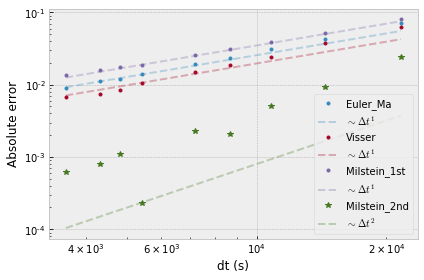

In [28]:
#weak_conEM=np.load("Weak_EM.npy")
#weak_conM2=np.load("Weak_M2.npy")
#weak_conVi=np.load("Weak_Vi.npy")
#weak_conM1=np.load("Weak_M1.npy")
#dtLa_array=np.load("dtArray.npy")

#pick a point to make line of some order.
i = 3 


fig=plt.figure(1)
l, = plt.plot(dtLa_array, weak_conEM,".",label = "Euler_Ma")
plt.plot(dtLa_array, (weak_conEM[i]/dtLa_array[i]**1) * dtLa_array**1, "--",
         c = l.get_color(), label = "$\sim \Delta t^1$", alpha=0.3)

l, = plt.plot(dtLa_array, weak_conVi,".",label = "Visser")
plt.plot(dtLa_array, (weak_conVi[i]/dtLa_array[i]**1) * dtLa_array**1, "--",
         c = l.get_color(), label = "$\sim \Delta t^1$", alpha=0.3)

l, = plt.plot(dtLa_array, weak_conM1,".",label = "Milstein_1st")
plt.plot(dtLa_array, (weak_conM1[i]/dtLa_array[i]**1) * dtLa_array**1, "--",
         c = l.get_color(), label = "$\sim \Delta t^1$", alpha=0.3)

l, = plt.plot(dtLa_array, weak_conM2,"*",label = "Milstein_2nd")
plt.plot(dtLa_array, (weak_conM2[i]/dtLa_array[i]**2) * dtLa_array**2, "--", 
         c = l.get_color(), label = "$\sim \Delta t^2$", alpha=0.3)

plt.xlabel('dt (s)')
plt.ylabel('Absolute error')
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()
plt.legend()
